# Introduction to Hamiltonian Monte Carlo

Vinay Ramasesh, September 2018 <br>
Comments/questions/errata welcome: ramasesh@berkeley.edu

This notebook is an updated one originally written for a [Machine Learning at Berkeley](https://ml.berkeley.edu) reading group given Fall 2018, discussing the paper [Generalizing Hamiltonian Monte Carlo with Neural Networks](https://arxiv.org/pdf/1711.09268.pdf) by Daniel Levy et al.  This notebook doesn't discuss the paper itself, but rather aims to introduce Hamiltonian Monte Carlo to undergraduates studying physics or CS who have limited-to-no experience with sampling, and only a basic understanding of probability distributions.  

Hamiltonian Monte Carlo is a technique for sampling from probability distributions which works well in high dimensions.  In this notebook, we first discuss the concept of sampling and its importance.  Then, we show a simple method of sampling, using the inverse CDF, as s warm up.  We then move on to Monte Carlo methods, discussing the Metropolis algorithm.  Finally, we discuss the Hamiltonian Monte Carlo algorithm itself.  

In [1]:
import numpy as np
from scipy.special import erf, erfinv

import matplotlib.pyplot as plt
%matplotlib inline

## Sampling from a distribution

In this notebook, we'll look at Hamiltonian Monte Carlo, a method to *sample* from a given probability distribution.  Given a probability distribution $p_X(x)$, sampling from a distribution simply means generating a set of values $\{x_i\}$, called *samples*, such that the statistics of the samples match that of the distribution.  For example, tossing a fair coin is an instance of sampling from the distribution $P(\mathrm{Heads}) = P(\mathrm{Tails}) = 0.5$.

There are a few reasons sampling is an important task.  One of them is that when given a complicated, multi-dimensional distribution, even if the distribution is completely specified, computing things like expectations, variance, or other functions of the random variables requires often-intractable integrals to be evaluated, e.g. for a function $f(x_1, ..., x_N)$:
\begin{equation}
\langle  f \rangle = \int ... \int f(x_1, ..., x_N) p_{\{x_i\}}(x_1, ..., x_N) dx_1 ... dx_N
\end{equation}
Note that *intractable* here means both analytically and numerically intractable!  In low dimensions, a numerical approximation to the integral might be accurate, but in high dimensions (say, several hundred or above), the space is simply too large to be discretized efficiently.  Sampling comes to our aid here.  Instead of computing the integral, one instead generates samples from the distribution $p_{\{x_i\}}$, calculates the value of $f$ at each of these sampled points, takes an average:
\begin{equation}
\langle  f \rangle \approx \frac{1}{N_S} \sum_{n = 0}^{N_S} f(s_n),
\end{equation}
where $s_n$ is the $n^{\mathrm{th}}$ sampled value and $N_S$ is the number of samples generated.  Of course, for this approximation to be valid, it must be possible to sample the $s_n$ values from the distribution $p_{\{x_i\}}$.

A second reason for the importance of sampling is that in some cases, we don't have a fully analytic expression for the distribution itself, but only know it's value at every point up to a normalizing constant.  Rather than knowing $p_{\{x_i\}}(\{x_i\})$ explicitly, we know a proportional function $f(\{x_i\}) = \mathcal{N} p_{\{x_i\}}(\{x_i\})$, but do now know the value of $\mathcal{N}$.  One common example of this situation occurs in statistical mechanics, where for a system in thermal equilibrium at temperature $T$, the probability of finding the system in state $i$ with energy $E_i$ is given by 
\begin{equation}
p_i(i) = \frac{e^{-E_i/(k_B T)}}{Z(T)},
\end{equation}
where $Z$, the partition function, is essentially a normalizing constant given by 
\begin{equation}
Z(T) = \sum_j e^{-E_j/(k_B T)}.
\end{equation}
In many systems of interest, explicit calculation of the partition function is hopeless.  In statistical modeling, this idea occurs in the form of *energy-based models*, which assign an energy to each value of the random variables and convert that energy to a probability in the same way.  Again, the partition function is usually difficult to calculate.  In these cases, we can still use the methods described in this notebook to sample from the distribution, and thus compute quantities of interest.  Remarkably, knowledge of the normalizing constant turns out to be unnecessary for the algorithms we will encounter.  

## Warm-up: sampling in the 1D case where the pdf is exactly known

Before getting into tough cases, let's see one way in which we might sample from a simple distribution which we *do* know exactly, even up to the normalizing constant.   **We'll assume that we have do access to a basic sampler, capable of sampling from the uniform distribution on the interval [0,1].**   We'll use this ability as a base, and build from it to being able to sample from more complicated distribution.  For a concrete example, take the triangular probability distribution given by 
\begin{equation}
p_X(x) =     \begin{cases}
      1+x & x\in [-1,0] \\
      1-x & x\in [0,1] \\
      0  & \mathrm{otherwise}
    \end{cases}
\end{equation}
<img src="triangle.png">
How can we generate samples from this completely known distribution, using our ability to sample uniformly from the [0,1]?  It's worth spending a few minutes thinking about this before reading ahead.

If we know the PDF, then we can also evaluate the CDF, or [cumulative distribution function](https://en.wikipedia.org/wiki/Cumulative_distribution_function), given by $P_X(x) \equiv \mathrm{Prob}(X \leq x)$ (here the capital letter $X$ stands for the random variable, while the lowercase $x$ is the argument to the function), simply by integrating the PDF from $-\infty$ to $x$:
\begin{equation}
P_X(x) = \int_{-\infty}^x p_X(x') ~dx'.
\end{equation}
Note that the CDF is a monotonically increasing function (because the PDF is non-negative) and therefore, is one-to-one and invertible.  Now think about what the CDF means.  If, at a particular value $x$, the CDF evaluates to, say $0.7$, this means that over many repetitions of $X$, $70%$ of the time, $X$ will take on a value less than $x$.  Compare this to sampling a uniform random variable from $[0,1]$ and obtaining the value $0.7$.  Again, in this case, this value is larger than $70%$ of values that we would obtain with repeated trials.  Thus, if we sample from the uniform distribution, obtain a value $s$, and convert that into a value of $x$ by finding the point at which the CDF $P_X(x) = s$, then the statistics of $x$ exactly match that of $p_X(x)$!  In other words, to sample from an arbitrary known PDF in one dimension, we simply sample uniformly from the unit interval and apply the *inverse* CDF: $x = P_X^{-1}(s)$, and we have our sample from $p_X(x)$. That's all there is to it.  

Before showing numerically that this works, let us explain why it works in another way.  Given a random variable $X$, we can make a function of that random variable, which is itself a random variable.  We can thus calculate the probability distribution for this new random variable.  For a one-to-one function, this is straightforward.  Let us call the function $f(x)$, and call the corresponding random variable $F$, and the PDF of the function $p_F(y)$. Then, 
\begin{eqnarray}
p_F(y) &\equiv& \lim_{dy\rightarrow 0}\mathrm{Prob}( F \in [y, y+dy])/dy \\
&=&  \frac{d}{dy} P_F(y) \\
&=& \frac{d}{dy} \mathrm{Prob} (f(X) \leq y) \\
&=& \frac{d}{dy} \int_{-\infty}^{f^{-1}(y)} p_X(x)~dx \\
&=& p_X(f^{-1}(y))  \frac{d}{dy} f^{-1}(y) \\
&=& \frac{p_X(f^{-1}(y))}{\frac{df}{dy}\bigg\rvert_{f^{-1}(y)}}
\end{eqnarray}
This might look ugly, but if you look at the final expression, it is pretty intuitive.  The probability density of $F$ taking on some value, $y$, is almost the same as the probability density for $X$ to take on the value $f^{-1}(y)$, except we have to scale by the slope of the function $f$ at that point.  That's it.  Now, using this, let's take the function $f$ to be the CDF of the variable $X$ itself: that is, we ask, what is the distribution of the CDF $P_X(x)$?  This might seem like a strange question, but it's perfectly well defined.  Operationally, you can think of it like this:  keep drawing samples of $X$, calculate the CDF of each value, and make a histogram of those CDFs.  This is an approximation to the distribution of the CDF.  Now, if we plug in the CDF to the above expression, and use the fact that the derivative of the CDF is simply the PDF, we can see that the distribution looks like:
\begin{eqnarray}
p_{CDF}(y) &=& \frac{p_X(CDF^{-1}(y))}{p_X(CDF^{-1}(y))} \\ 
&=& 1,
\end{eqnarray}
independent of the probability distribution!  Since the CDF is always uniformly distributed between $[0,1]$, we can sample uniformly from that interval and treat the sampled value as the CDF.  Then, to get the random variable we wanted to sample, we apply the inverse CDF.  

Now that we have two ways to understand the logic behind the inverse-CDF method, let's see it in action for the triangle distribution above.  We need to calculate the inverse CDF, so first let's calcualte the CDF, $P_X(x)$:
\begin{equation}
P_X(x) =     \begin{cases}
      0 & x < -1 \\
      0.5(1+x)^2 & x\in [-1,0] \\
      1-0.5(1-x)^2 & x\in [0,1] \\
      1  & x>1 
    \end{cases}
\end{equation}
And now the inverse CDF:
\begin{equation}
P_X^{-1}(x) =     \begin{cases}
      \sqrt{2x} -1 & x\in [0,0.5] \\
      1-\sqrt{2-2x} & x\in [0.5,1] \\
    \end{cases}
\end{equation}


In [30]:
def triangle_pdf(x):
    return np.heaviside(x+1,1)*np.heaviside(-x,0)*(x+1)+ np.heaviside(1-x,1)*np.heaviside(x,1)*(1-x)
    
def triangle_cdf(x):
    return np.heaviside(x+1,1)*np.heaviside(-x,0)*0.5*np.power(x+1,2)+ np.heaviside(1-x,1)*np.heaviside(x,1)*(1-0.5*np.power((1-x),2)) + np.heaviside(x-1,0)

def triangle_invcdf(x):
    return np.heaviside(x,1)*np.heaviside(0.5-x,1)*(np.sqrt(2*x)-1) + np.heaviside(x-0.5,0)*np.heaviside(1-x,1)*(1-np.sqrt(2-2*x))


Let's quickly verify that the calculation of the inverse CDF is correct, by checking that $P^{-1}_X(P_X(x)) = x$:

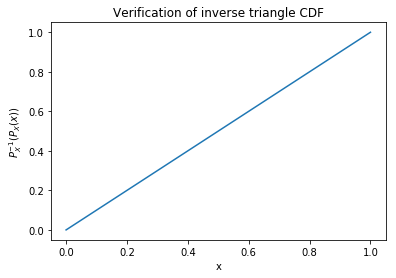

In [36]:
x = np.linspace(0,1,50)
plt.plot(x, triangle_invcdf(triangle_cdf(x)))
plt.xlabel('x')
plt.ylabel('$P_X^{-1}(P_X(x))$')
plt.title("Verification of inverse triangle CDF");

Good.  Now let's sample using the inverse CDF method and see the histogram of the results.

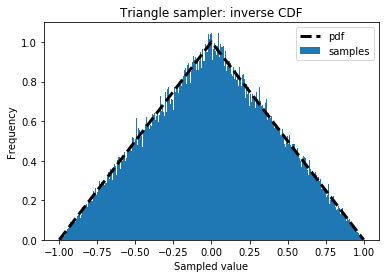

In [55]:
n_samples = 100000
#generate uniform samples
uniform_samples = np.random.uniform(size=n_samples)

#apply inverse cdf
triangle_samples = triangle_invcdf(uniform_samples) 
plt.hist(triangle_samples,density=True,bins=300, label='samples');

#ovelay the pdf
x = np.linspace(-1,1,11)
plt.plot(x, triangle_pdf(x), linewidth=3, ls='--', color='black', label='pdf')

#add labels, etc.
plt.legend(loc=1)
plt.xlabel('Sampled value')
plt.ylabel('Frequency')
plt.title('Triangle sampler: inverse CDF');

Great!  So the inverse CDF trick seems to work.  Let us also verify that it works for a Gaussian distribution, both to see the method in action a second time *and* because sampling from the Gaussian distribution will be a necessary ingredient in Hamiltonian Monte Carlo.  

In [129]:
def gaussian_pdf(x, mu=0, sigma=1):
    return 1/np.sqrt(2*np.pi*np.power(sigma,2))*np.exp(-np.power((x-mu)/sigma, 2)/2)

def gaussian_cdf(x, mu=0, sigma=1):
    return (1+erf((x-mu)/(np.sqrt(2)*sigma)))/2

def gaussian_invcdf(x, mu=0, sigma=1):
    return erfinv((2*x-1))*np.sqrt(2)*sigma+mu

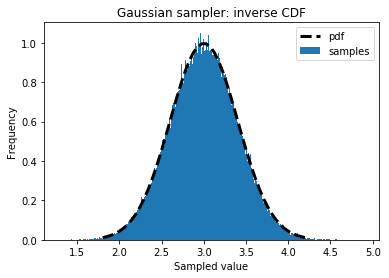

In [103]:
n_samples = 100000

mu = 3
stdev = 0.4

#generate uniform samples
uniform_samples = np.random.uniform(size=n_samples)

#apply inverse cdf
gaussian_samples = gaussian_invcdf(uniform_samples, mu, stdev) 
plt.hist(gaussian_samples,density=True,bins=300, label='samples');

#ovelay the pdf
x = np.linspace(mu-3*stdev,mu+3*stdev,50)
plt.plot(x, gaussian_pdf(x, mu, stdev), linewidth=3, ls='--', color='black', label='pdf')

#add labels, etc.
plt.legend(loc=1)
plt.xlabel('Sampled value')
plt.ylabel('Frequency')
plt.title('Gaussian sampler: inverse CDF');

Run the above cell a few times using different values of $\mu$ and $\sigma$ to convince yourself that the method works. We now have the ability to sample from an arbitrary, known distribution in 1D, built just from the ability to sample uniformly from $\left[0, 1\right]$ (which is essentially saying we can flip an unbiased coin).  Unfortunately, as you might imagine, this method does not generalize to multiple dimensions, nor does it work if we only know the PDF up to a normalizing constant.  In the next section, we will begin to look at random-walk-based methods (of which Hamiltonian Monte Carlo is one), which overcome both difficulties.

First, however, let us note one nice property of the inverse-CDF-generated samples.  Because the uniform samples we started with were uncorrelated, they are still uncorrelated after applying the inverse CDF.  That is, we've generated a set of samples $\{x_i\}$ which are not only drawn from the desired distribution, but are also *independent*.  This might seem obvious, but we'll see later that a downside of the random-walk based methods is that they don't have this property!  To show that the samples are uncorrelated, we can simply compute the autocorrelation numerically, which should have a single peak at $\mathrm{delay}=0$ and be nearly zero everywhere else.  

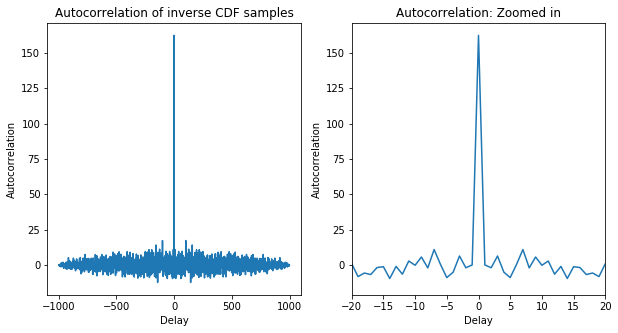

In [114]:
n_samples = 1000

uniform_samples = np.random.uniform(size=n_samples)
triangle_samples = triangle_invcdf(uniform_samples) 
autocorr = np.correlate(triangle_samples, triangle_samples, mode='full')
delays = np.arange(-n_samples+1, n_samples)

plt.figure(figsize = (10,5))
plt.subplot(121)
plt.plot(delays, autocorr)
plt.xlabel('Delay')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of inverse CDF samples')

plt.subplot(122)
plt.plot(delays, autocorr)
plt.xlabel('Delay')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation: Zoomed in')
plt.xlim(-20,+20);

As you can see, only exactly at a delay of zero does the autocorrelation take on a non-zero value (up to noise), indicating that the samples are truly uncorrelated.  Before moving on, we'll write a function which does this inverse CDF sampling so that we can compare its workings with the Monte Carlo methods below.

In [116]:
def sample_CDF(inverse_CDF, num_samples=1000):
    """ Samples from a specified probability distribution, 
    (specified here by giving the inverse of the CDF)
    by generating a uniform random from 0 to 1 and applying the inverse CDF """

    uniform_samples = np.random.uniform(size=num_samples)
    pdf_samples = inverse_CDF(uniform_samples)

    return pdf_samples

## Markov-chain Monte Carlo: Sampling using a random walk

Now we'll look at sampling using a class of methods collectively known as *Markov-chain Monte Carlo (MCMC)*, essentially a fancy name for algorithms which use a random walk to traverse the distribution to sample.  The simplest MCMC algorithm, known as the Metropolis algorithm, proceeds as follows:

### Metropolis algorithm
0. Call the PDF to sample from $p_{\mathrm{sam}}(x)$
1. Start at a randomly-chosen point, $x_0$.  This is the first sample.  
**Generate new samples as follows:**
2. Using a probability distribution, $p_{\mathrm{step}}(s)$, from which we know how to sample (say, a Gaussian), take a sample from that distribution.  This is the step, $s$.  **For the Metropolis algorithm, the step distribution must be symmetric, i.e. $p_{\mathrm{step}}(s) = p_{\mathrm{step}}(-s)$ for all $s$.**
3. Test the point $x_0 + s$ by comparing $p_{\mathrm{sam}}(x_0 + s)$ with $p_{\mathrm{sam}}(x_0)$.  If the value at the new point $x_0 + s$ is higher, then we *accept* this point.  That is, the next sample is $x_0 + s$.  If the value at the new point is *lower*, then we can still accept the new point, but we do so probabilistically, with probability $p_{\mathrm{sam}}(x_0 + s)/p_{\mathrm{sam}}(x_0)$.  If the new point is rejected, then the next sample is $x_0$, same as it was previously.  
**Repeat steps 2 and 3 until the desired number of samples has been generated.**

It is certainly not obvious that this algorithm produces samples correctly distributed according to the desired distribution $p_{\mathrm{sam}}(x)$.  We will prove that it does in a little while.  But first, note one nice feature of the algorithm: nowhere is the true value of the PDF required.  All we need to know are the *ratios* between the values of the PDF at any two points, to determine whether we accept or reject potential samples.  So, if all we know is the distribution up to a normalizing constant, we can still use this algorithm.  Likewise if all we know is the energy of each configuration; we simply exponentiate the difference in energies to get the ratio of the probabilities.  This is a key feature of MCMC algorithms.  

Now let's code up the Metropolis algorithm.  We need to provide a function that samples from $p_{\mathrm{step}}(s)$.  In the default case we'll leave this distribution as the standard unit Gaussian, i.e. ``np.random.randn()``, though for later we'll also add the ability to choose the variance of the Gaussian.  (Note that this isn't cheating because we've already worked out how to sample from a Gaussian!) We also need to provide an initial point, the desired number of samples, and the distribution function itself.  Look at the code below and make sure you understand the implementation.

In [136]:
def sample_metropolis(prob_distribution_func, num_samples=1000, initial_point=0, step_generating_stdev=1):
    """ Samples from a specified one-dimensional distribution (pdf), with a random-walk approach.
    
    Starts at an initial_point, then generates a random step using np.random.randn(), multiplied by 
    step_generating_stdev,to find a new point.  Then, it accepts or rejects the move with probability 
    given by the ratio of the new and old pdf values """

    samples = np.zeros(num_samples)


    step_generating_function = lambda: step_generating_stdev*np.random.randn()
    
    current_point = initial_point
    for i in range(num_samples):
        samples[i] = current_point
        current_prob = prob_distribution_func(current_point)

        # Move to new point
        proposed_step = step_generating_function()
        proposed_new_point = current_point + proposed_step

        # Test whether to accept
        new_prob = prob_distribution_func(proposed_new_point)
        prob_ratio = new_prob / current_prob    
        accepted = np.random.uniform() < prob_ratio
      
        if accepted:
            current_point = proposed_new_point
        else:
            current_point = current_point
    return samples

Now, let's see the method in action.  First, we'll use it on the triangle distribution.

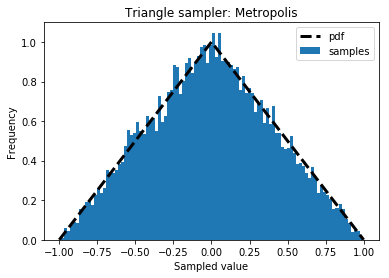

In [137]:
n_samples = 50000
triangle_MC_samples = sample_metropolis(triangle_pdf, num_samples=n_samples)

#plot samples
plt.hist(triangle_MC_samples,density=True,bins=100, label='samples');

#ovelay the pdf
x = np.linspace(-1,1,11)
plt.plot(x, triangle_pdf(x), linewidth=3, ls='--', color='black', label='pdf')

#add labels, etc.
plt.legend(loc=1)
plt.xlabel('Sampled value')
plt.ylabel('Frequency')
plt.title('Triangle sampler: Metropolis');

Good, so the Metropolis sampler seems to work too.  We said before that we don't need to know the exact value of the PDF, though, only the PDF up to a normalizing constant.  In the cell below, let's test this.  Play with the value of the ``multiplier`` to give the Metropolis algorithm an unnormalized PDF, and see how it performs.

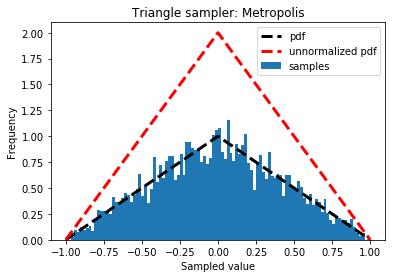

In [222]:
n_samples = 10000
multiplier = 2
def multiplied_pdf(multiplier, original_pdf):
    return lambda x: multiplier*original_pdf(x)
multiplied_triangle = multiplied_pdf(multiplier, triangle_pdf)

triangle_MC_samples = sample_metropolis(multiplied_triangle, num_samples=n_samples)

#plot samples
plt.hist(triangle_MC_samples,density=True,bins=100, label='samples');

#ovelay the pdf
x = np.linspace(-1,1,11)
plt.plot(x, triangle_pdf(x), linewidth=3, ls='--', color='black', label='pdf')
plt.plot(x, multiplied_triangle(x), linewidth=3, ls='--', color='red', label='unnormalized pdf')


#add labels, etc.
plt.legend(loc=1)
plt.xlabel('Sampled value')
plt.ylabel('Frequency')
plt.title('Triangle sampler: Metropolis');

You should see above that regardless of the value of ``multiplier`` you put in, the samples are returned correctly from the normalized, triangle PDF.  So, the first problem with the inverse CDF sampling, that it only worked for fully known distributions, is not a problem with the Metropolis-Hastings algorithm.  The second problem we had with the inverse CDF method was that it wasn't clear how to generalize it to multiple-dimensions.  But this is also easy to overcome with Metropolis: we just generate a different step for each dimension, and run the algorithm as specified.  No problem.  

Unfortunately, this does not mean that everything is perfect with the Metropolis algorithm (otherwise we wouldn't need something like Hamiltonian Monte Carlo).  We can immediately point to two undesirable aspects.  First, correlation.  In a sequence of $N$ samples $\{x_i\}$ produced with Metropolis, the value of the sample $x_n$ is certainly not independent of the value of $x_{n-1}$.  This is because the sample $n$ is produced by starting at the value $x_{n-1}$ and then moving some distance $s$.  Clearly, the samples will be correlated.  We can see this by plotting the autocorrelation as we did before for the inverse CDF method.  

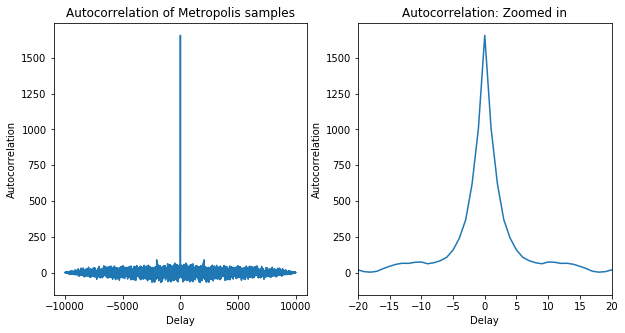

In [139]:
autocorr = np.correlate(triangle_MC_samples, triangle_MC_samples, mode='full')
delays = np.arange(-n_samples+1, n_samples)

plt.figure(figsize = (10,5))
plt.subplot(121)
plt.plot(delays, autocorr)
plt.xlabel('Delay')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of Metropolis samples')

plt.subplot(122)
plt.plot(delays, autocorr)
plt.xlabel('Delay')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation: Zoomed in')
plt.xlim(-20,+20);

In the zoomed in plot, the correlation is clear as day!  Unlike the independent inverse CDF samples, there's clearly a non-zero value of the correlation for non-zero separation.  This is a pretty big downside of the Metropolis algorithm, given that many applications require *independent* samples from the given distribution.  

We might imagine that the lack of independence can be ameliorated by making the step-generating distribution (or, as it's more properly called, the *proposal distribution*) higher-variance.  That way, on average we'll move farther from the point $x_n$ to generate the point $x_{n+1}$ and thus the influence of $x_n$ on this value should be lessened.  In the cell below, we explore this conjecture numerically for the triangle distribution, by tweaking the value of the variance:

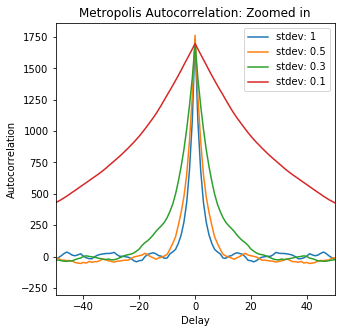

In [184]:
stdevs = [1, 0.5, 0.3, 0.1]
n_samples = 10000
delays = np.arange(-n_samples+1, n_samples)

autocorrs = {}
samples_MC = {}

plt.figure(figsize = (5,5))

for stdev in stdevs:
    triangle_MC_samples = sample_metropolis(triangle_pdf, num_samples=n_samples, step_generating_stdev=stdev)
    samples_MC[stdev] = triangle_MC_samples
    autocorrs[stdev] = np.correlate(triangle_MC_samples, triangle_MC_samples, mode='full')

    plt.plot(delays, autocorrs[stdev], label=f'stdev: {stdev}')

plt.xlabel('Delay')
plt.ylabel('Autocorrelation')
plt.title('Metropolis Autocorrelation: Zoomed in')
plt.xlim(-50,+50);
plt.legend(loc=1);

From the above plot, it seems like our conjecture was true: as we chose the standard deviation to increase, the autocorrelation of the Metropolis samples decreased.  Running with this train of thought, what if we increase the stdev of the proposal distribution still further?  Maybe we can eliminate the autocorrelation altogether.  Let's try it:

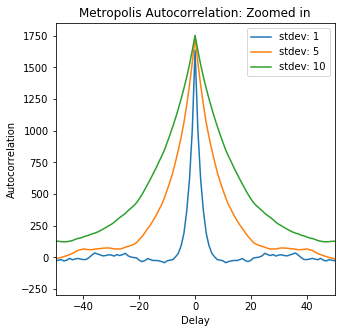

In [187]:
stdevs = [1, 5, 10]
n_samples = 10000
delays = np.arange(-n_samples+1, n_samples)

plt.figure(figsize = (5,5))

for stdev in stdevs:
    triangle_MC_samples = sample_metropolis(triangle_pdf, num_samples=n_samples, step_generating_stdev=stdev)
    samples_MC[stdev] = triangle_MC_samples
    autocorrs[stdev] = np.correlate(triangle_MC_samples, triangle_MC_samples, mode='full')

    plt.plot(delays, autocorrs[stdev], label=f'stdev: {stdev}')

plt.xlabel('Delay')
plt.ylabel('Autocorrelation')
plt.title('Metropolis Autocorrelation: Zoomed in')
plt.xlim(-50,+50);
plt.legend(loc=1);

Whoops.  It seems like our conjecture was not exactly right.  In the case where the standard deviation of the proposal distribution is greater than unity, it seems like an increase in the stdev actually increases degree of correlation, which is exactly the opposite of what we wanted.  

How did our intuition fail for this case?  We said that if the proposal distribution got wider, on average the steps would be larger, and tehrefore the influence of the initial point would be lessened.  What we neglected to consider, however, was the fact that as the step size increased, the probability of accepting the move would decrease (think about leaving the central peak of the mountain and arriving somewhere in the wings, or going off the support of the PDF entirely).  So, what we should expect to see for a very large step size is that most of the moves actually get rejected.  In fact, we can see this quite easily in the samples generated for, say, $\sigma = 10$ and $\sigma = 0.1$, above:

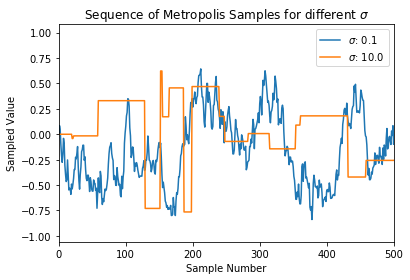

In [167]:
min_stdev = np.min(list(samples_MC.keys()))
max_stdev = np.max(list(samples_MC.keys()))

for stdev in [min_stdev, max_stdev]:
    plt.plot(samples_MC[stdev], label = f'$\sigma$: {stdev}')
plt.xlim(0,500)
plt.title('Sequence of Metropolis Samples for different $\sigma$')
plt.xlabel('Sample Number')
plt.ylabel('Sampled Value');
plt.legend(loc=1);

The above plot shows two very different types of behavior for the two values of $\sigma$.  For small step sizes (blue), the behavior can be described as *diffusive*: each step is very small, but usually the steps get accepted.  There don't seem to be large stretches of time for which the sampler gets stuck in one spot.  On the other hand, for large step sizes (orange), the sampler is stuck almost all the time!  Only occasionally does the sampler accept a move.  

So, both for very large $\sigma$, and very small $\sigma$ of the proposal function, it seems like we end up with correlated samples, though for different reasons.  In the small $\sigma$ case, the correlation is due to the fact that the moves, though generally accepted, are small, whereas in the large $\sigma$ case, it's due to the fact that we don't often make moves.  

One other fun way to see the fact that the variables $x_n$ and $x_{n+1}$ are correlated is to look at the joint probability distribution function of the two, i.e. $p_{x_1,x_2}(x_1, x_2)$: 

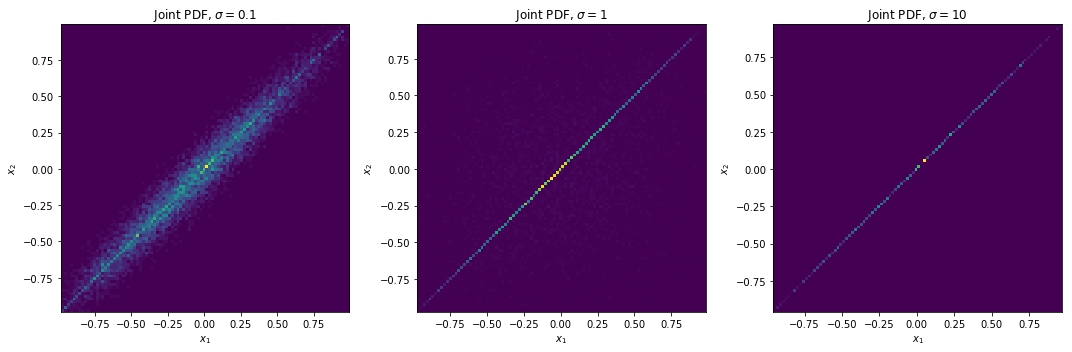

In [188]:
stdevs_to_plot = [0.1, 1, 10]

plt.figure(figsize = (15,5))

for i,stdev in enumerate(stdevs_to_plot):
    plt.subplot(1,3,i+1)
    plt.hist2d(samples_MC[stdev][:-1],samples_MC[stdev][1:], bins=100, normed='True');
    plt.title(f'Joint PDF, $\sigma=${stdev}')
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
plt.tight_layout()

Above, we see an incredible amount of correlation betwen $x_n$ and $x_{n+1}$.  Even though marginalizing over either variable leads to the correct 'single-particle' PDF, it is clear that the variables $x_n$ and $x_{n_1}$ are not close to being independent.  

So, in practice, how do we get around this problem of autocorrelation when using the Metropolis algorithm?  One thing we can do is to throw out most of the samples Metropolis gives us.  Say, for example, the autocorrelation decays sufficiently by the time the separation gets to ten (this seems to be the case when we use $\sigma=1$ above).  Then, we can just take every ten sample from the original sequence returned by Metropolis, discarding the rest.  The obvious downside here is that we lose a lot of data. But, as you can see in the plots below, once we do this, at least for the case of $\sigma = 1$, we do get a seemingly uncorrelated joint distribution.

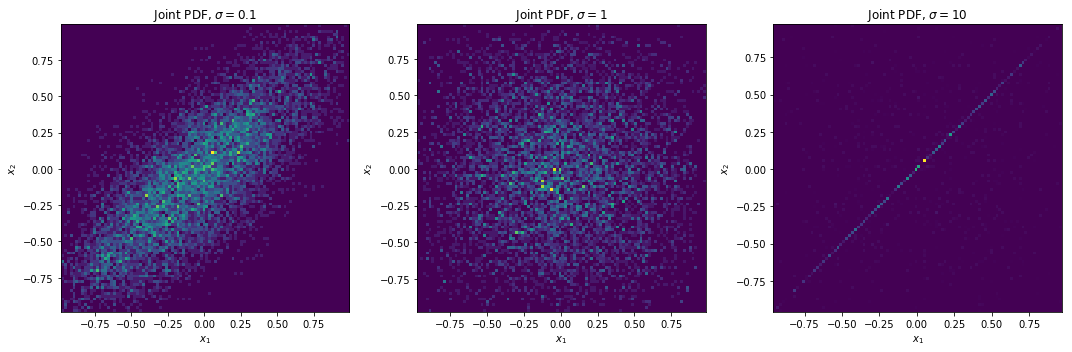

In [194]:
stdevs_to_plot = [0.1, 1, 10]

plt.figure(figsize = (15,5))

throw_away = 10

for i,stdev in enumerate(stdevs_to_plot):
    plt.subplot(1,3,i+1)
    plt.hist2d(samples_MC[stdev][:-throw_away],samples_MC[stdev][throw_away:], bins=100, normed='True');
    plt.title(f'Joint PDF, $\sigma=${stdev}')
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
plt.tight_layout()

In practice, how do we know how many samples we have to throw away to get uncorrelated results?  I'm not sure.  In one dimension, it's probably easy enough to compute the autocorrelation as we did above and then visually inspect the decay, but I would imagine that this computation gets very expensive very fast as the number of dimensions grows.  

The autocorrelation is thus one downside of Metropolis.  We mentioned above that there were two downsides.  The second is known as the *burn-in* period.  This is easier to illustrate (a) with a Gaussian distribution than a triangle distribution, and (b) when we begin the sampler not at $x_0=0$, but rather very far from the center of the distribution.  Basically, the burn-in period is the sequence of initial samples which are more dependent on the initial point than the distribution itself: the sampler has not yet *settled* to the correct distribution.  

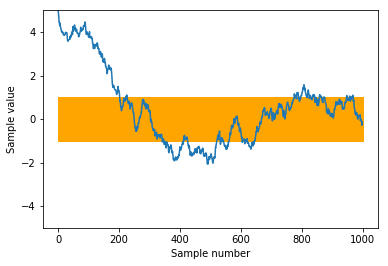

In [223]:
n_samples = 10000
gaussian_MC_samples = sample_metropolis(gaussian_pdf, num_samples=n_samples, initial_point=5, step_generating_stdev=0.1)

zoom_region = 1000
plt.plot(gaussian_MC_samples[:zoom_region])
plt.fill_between([0,zoom_region],[-1,-1],[1,1], color='orange')
plt.xlabel('Sample number')
plt.ylabel('Sample value')
plt.ylim(-5,5);


Here the orange-shaded region indicates the $1\sigma$ region of the Gaussian.  Notice that the initial roughly two-hundred points sampled clearly do not seem to come from the Gaussian distribution: rather, they occur because we started the sampler very far away from the region of high-probability, and gave it a very small step size so it had to wander for a while before settling in to the correct distribution.  So, this set of burn-in samples introduces a bias to the whole set.

As with the autocorrelation problem, the way to correct for this bias is to throw out data.  This time, we throw out the first $n$ samples.  But how to properly choose $n$?  Again, the one-dimensional visualization we've done here is not easy in higher dimensions.  As I understand it, choosing this number well is not really a generally-solved problem; rather, depending on the circumstance (i.e. the precise distribution to sample), different imperfect heuristics exist.  

In practice, we often want to sample from very high-dimensional distributions.  Here, the Metropolis algorithm (or any random-walk based Monte Carlo algorithm, really) will suffer from another shortcoming: it will be hopelessly inefficient!  In high dimensions, there are several directions in which the proposal distribution might choose to take us, and most of them will lead to regions of extremely low probability.  Hamiltonian Monte Carlo hopes to get around this problem.  Before we can see how it works, however, let us pause to show why the Metropolis algorithm works. 

### Why the Metropolis algorithm works

We've talked a lot about the Metropolis algorithm without actually understanding why it works.  Let's remedy that now.  The key is to realize that the Metropolis algorithm, the process by which we generate samples $\{x_i\}$, is a particular type of stochastic process known as a *Markov process* or *Markov chain*.  If you are unfamiliar with Markov chains, we will briefly review them here.  Readers with a solid understanding of Markov chains can feel free to skip the following section.

#### Review of Markov chains

A Markov chain is just a random walk. Though we've been working with continuous random variables, i.e. random variables which can take the value of any real number, Markov chains are simpler to understand in the finite case.  Consider a random variable with $N$ possible values, say, $\{1, ..., N\}$.  We can imagine a person walking between $N$ different places, **as shown below (TODO)**.  In this notebook, we'll only worry about *discrete-time* Markov processes, where at each time-step, the walker goes to a new site (i.e., their movement only occurs at discrete time intervals).  If the walker randomly chooses their steps randomly, the position of the walker at each time-step is a stochastic process.  This stochastic process is said to be a Markov process if knowledge of the walker's current position determines the probability distribution of the walker's next move.  

**insert image here**

It's probably easiest to understand the Markov property by showing examples where it fails to hold.  Say that $N = 3$, and the three places in question are $\{ \mathrm{Home, Car, School} \}$.  Then, if our current position is $\mathrm{Car}$, then it's quite likely that knowledge of the previous position will give some additional information as to our next position.  For example, if we're currently in $\mathrm{Car}$ and were previously in $\mathrm{Home}$, then it's overwhelmingly likely that our next move is $\mathrm{School}$.  Thus, the process is not Markovian.  In a Markovian process, if we know the current position, we don't learn anything else about the walker's future possibilities by learning about the previous positions.  

A Markov chain can be completely specified by giving, for every possible site, the probability to go from that site to every other site.  This set of probabilities is known as the transition matrix, where the element $P_{ij}$ represente the probability to go from $\mathrm{site}~ i \rightarrow \mathrm{site}~ j$. 

Suppose one walker starts on a particular site, say site 1.  Another walker, traversing the same Markov chain, starts on a different site, say site 3.  It seems reasonable to imagine that after many, many steps, the distributions of both walkers will be the same.  That is, the walkers will eventually settle into some distribution which is only a characteristic of the transition matrix and does *not* depend on the initial condition.  There is a theorem to this effect (we won't prove it here), which holds as long as it is possible to reach, in some finite number of steps, any state from any other.  In this case, the chain has a unique *stationary distribution* to which all walkers will eventually converge.

How does one calculate this stationary distribution?  If we start a walker in the stationary distribution, and evolve for a step, the distribution should still be the stationary distribution.  Thus, given a transition matrix $P_{ij}$, the stationary distribution $p_k$ needs to satisfy
\begin{equation}
\sum_k P_{ik} p_k = p_i,
\end{equation}
meaning that the stationary distribution is the (unique) eigenvector of the transition matrix with unit eigenvalue.  

#### Detailed balance

There is another way to describe the stationary distribution of a Markov chain.  Namely, the stationary distribution is the one which satisfies *detailed balance*.  This is nothing more than saying that at every timestep, the flow from site i to site j is the same as the flow from site j to site i.  The flow from site i to site j is simply the probability to be at site i, $p_i$, multiplied by the transition probability from site i to site j, $P_{ij}$.  Likewise, the flow from site j to site i is the probability to be at site j, $p_j$, times the transition probability $P_{ji}$.  Therefore, if a distribution $p_i$ satisfies
\begin{equation}
p_i P_{ij} = p_j P_{ji},
\end{equation}
then it is the stationary distribution of the Markov chain $P_{ij}$.

#### Metropolis algorithm as a Markov chain

The Metropolis algorithm is an example of a Markov chain, since the probability of moving to a given point (or sample) $x$ depends only on the value of the current sample.  We will now show that the way we've set up the Markov chain implies that its stationary distribution is the one we want to sample from, $p_X(x)$.  All we have to do is show that it satisfies detailed balance.  To do that, take two values of the random variable, $x_i$ and $x_j$.  We will show that if the distribution of the walker is given by $p_X(x)$, then the flow from $x_i$ and $x_j$ is the same as that from $x_j$ to $x_i$.  Let's calculate the probability to go from $x_i$ to $x_j$, assuming without loss of generality that the PDF is higher at $x_i$ than $x_j$.  The probability has two parts: the probability to *propose* $x_j$ as the next point, i.e. the probability to choose a step size $s = x_j - x_i$, multiplied by the probability to *accept* $x_j$ if we do end up proposing it.  Thus, the probability is
\begin{equation}
P(x_i \rightarrow x_j) = p_{\mathrm{step}}(x_j - x_i) \frac{p_X(x_j)}{p_X(x_i)}.
\end{equation}
The probability to go from $x_j$ to $x_i$ is similar, except that since $x_i$ has a higher value of the PDF than $x_j$, we *always* accept the move if it is proposed.  Thus,
\begin{equation}
P(x_i \rightarrow x_j) = p_{\mathrm{step}}(x_i - x_j).
\end{equation}
To get the corresponding flows $F$, we multiply by the site occupation probability densities:
\begin{equation}
F(x_i \rightarrow x_j) = P(x_i \rightarrow x_j) p_X(x_i) = p_{\mathrm{step}}(x_j - x_i) p_X(x_j).
\end{equation}
And
\begin{equation}
F(x_j \rightarrow x_i) = P(x_j \rightarrow x_i) p_X(x_j) = p_{\mathrm{step}}(x_i - x_x) p_X(x_j).
\end{equation}
By symmetry of the step-generating function, these two are equal, and thus the stationary distribution of the Markov chain is the distribution we intended to sample from, $p_X(x)$.  This completes the proof.  

### Recap

In this section, we've seen that for probability densities which are either (a) not known explicitly, or (b) higher than one-dimensional, the Metropolis algorithm can be used to extract samples.  In essence, the Metropolis algorithm works by setting up a Markov chain whose stationary distribution is exactly the one we wish to sample from.  This algorithm does have shortcomings, however.  One shortcoming is that samples are not independent from each other; another is that the samples generated initially may not be properly distributed.  Both of these shortcomings can be circumvented by throwing away a lot of the samples.  

In high dimensions, we also mentioned that random-walk Monte Carlo methods will often propose samples with very low probability, and therefore will get rejected most of the time.  Now, we'll take a look at Hamiltonian Monte Carlo, another Markov-chain Monte Carlo algorithm which hopes to perform better than the basic random-walk Monte Carlo in higher dimensions.  Though it is still a Monte Carlo method, it uses information about the geometry of the distribution to navigate the region of high probability more efficiently.

## Hamiltonian Monte Carlo

Finally, we come to the idea of Hamiltonian Monte Carlo (HMC).  Let's emphasize that Hamiltonian Monte Carlo is just another instantiation of Markov-chain Monte Carlo, just like the Metropolis algorithm.  But, there are two main differences between HMC and the Metropolis algorithm:
1. **In HMC, we augment the state space (i.e., the values of the random variable) with another random variable, which we call (for reasons which will become clear soon) the *velocity* variable.**  We add one velocity variable for each dimension in the original distribution.  This means that if the distribution we're trying to sample from is one-dimensional, say $p_X(x) \propto \exp(-x^2/2)$, then we add a single velocity variable.  We always take each velocity to be uncorrelated with all other variables, such that in the 1D example the joint distribution is given by $p_{X,V}(x,v) = p_X(x) p_V(v)$.  Then, we perform a MCMC sampling on the joint distribution, and only look at the $x$ values.  This is effectively marginalization over the random variable $V$, and thus reproduces $p_X(x)$.  Also for reasons that will become clear soon, we take the velocity variable to be Gaussian-distributed with unit variance, that is $p_V(v) \propto \exp(-v^2/2)$.
2. **In HMC, we generate proposal values not by sampling from a distribution, but by equating the log of the PDF to an energy of an imagined particle and following the resulting (Newtonian) equations of motion.** In fact, this is the origin of the name *Hamiltonian* in Hamiltonian Monte Carlo: in classical physics, the function of position and momenta which gives the total system energy is known as the Hamiltonian, and the resulting equations of motion are known as Hamilton's equations.

Point 2 is likely not as familiar to a reader who hasn't taken an advanced undergrad course in classical mechanics, so let's unpack it a little more.  In the introduction, we mentioned energy-based models which assign to each configuration an energy, and conert that energy function into a probability distribution by exponentiating the negative of the energy.  In equations, the energy $U(\vec{x}, \vec{v})$ is converted to a probability distribution by writing
\begin{equation}
p_{\vec{x}, \vec{v}}(\vec{x}, \vec{v}) = \frac{e^{-U(\vec{x}, \vec{v})}}{Z},
\end{equation}
where $Z$, the partition function, is the normalizing contant defined by
\begin{equation}
Z = \int d^N\vec{x} ~ d^N\vec{v} ~ e^{-U(\vec{x}, \vec{v})}
\end{equation}
Remember that usually, the partition function is intractable, but since HMC is a Monte-Carlo method, we don't need to know it, since we just need the relative values of the PDF for different configurations, which is simply calculated by exponentiating energy differences:
\begin{equation}
\frac{p_{\vec{x}, \vec{v}}(\vec{x}_1, \vec{v}_1)}{p_{\vec{x}, \vec{v}}(\vec{x}_2, \vec{v}_2)} = e^{U(\vec{x}_2, \vec{v}_2)-U(\vec{x}_1, \vec{v}_1)}
\end{equation}
For the Gaussian distribution we discussed above, with 
\begin{equation}
p_{X,V}(x,v) \propto e^{-(x^2/2)}e^{-(v^2/2)},
\end{equation}
the corresponding energy function is 
\begin{equation}
U(x,v) = \frac{1}{2}x^2 + \frac{1}{2}v^2.
\end{equation}
Readers who remember their first course in physics should recognize this as the energy of a simple harmonic oscillator, with mass $m=1$ and spring constant $k=1$.  This energy function, known as the *Hamiltonian*, completely specifies the resulting dynamics of the system, by using Hamilton's equations:
\begin{eqnarray}
\frac{dx}{dt} &=& v(t) \\
\frac{dv}{dt} &=& -\frac{dU}{dx}\bigg\rvert_{x(t)}
\end{eqnarray}
We will often write $H(x,v)$ instead of $U(x,v)$, but these are the same.  There are a few features of the dynamics generated by the above equations which are important for the performance of Hamiltonian Monte Carlo:
1. ** Time-reversal symmetry ** - Classical physics governed by a Hamiltonian obeys *time-reversal symmetry*, in that if you stop the system at some time and reverse all the velocities, the particles will trace back their trajectories exactly.
2. ** Volume preservation ** - Instead of thinking of Hamilton's equations as ODEs, we can think of them as generating a map from $(x(t), v(t))$ to $(x(t+\Delta t), v(t+\Delta t))$.  This map preserves volume in the $(x,v)$ space, known as *phase space*.  This observation is known as *Liouville's theorem* in classical mechanics. <br> In the harmonic oscillator case above, volume preservation is easy to see.  Here Hamilton's equations become
\begin{eqnarray}
\frac{dx}{dt} &=& v(t) \\
\frac{dv}{dt} &=& -x(t)
\end{eqnarray}
These equations are solved by 
\begin{eqnarray}
x(t) &=& x(0)\cos{t} + v(0)\sin{t} \\
v(t) &=& -x(0)\sin{t} + v(0)\cos{t},
\end{eqnarray}
meaning that the map is simply a rotation in phase space by angle $t$.  This is of course volume preserving.
3. ** Conservation of the Hamiltonian (energy) ** - Because the Hamiltonian represents the total energy of the system, the dynamics conserve its value.  For the harmonic oscillator case, this is easy to see, since the total energy depends only on $x^2 + v^2$, i.e. the *radius* in phase space, which is definitely conserved by a rotation map. 

You might have thought initially that the Hamiltonian Monte Carlo procedure would be to start at some point in phase space and then follow the trajectory given by Hamilton's equations.  But, thinking about point 3 above, this is certainly not the case.  If we were to do this, then we'd always sample points that have the same value of the energy, or probability.  So, what we will actually do at each step is sample some velocity from the velocity distribution $p_V(v)$, and then follow Hamilton's equations.  We'll describe this precisely now.

### Hamiltonian Monte Carlo algorithm

With this background in place, we can explicitly go through the Hamiltonian Monte Carlo algorithm, using the Gaussian distribution as an example.  
0. ** Original Distribution ** <br>
We desire to sample from the distribution 
\begin{equation}
p_X(x) \propto e^{-x^2/2}
\end{equation}
1. ** Augmented state space ** <br>
First, we augment the state space with a single 'velocity' variable, also Gaussian-distributed, so that the joint distribution we would like to sample from is 
\begin{equation}
p_{X,V}(x,v) \propto e^{-(x^2/2)}e^{-(v^2/2)},
\end{equation}
2. ** Move around in the state space ** <br>
As with Metropolis, we start at some arbitrary point $(x_0, v_0)$ in the state space, generate a proposal point, and then choose whether to accept or reject.  However, rather than generating the point by randomly sampling from a proposal distribution, we will generate a new sample in two steps.
    1. Sample a new value of the velocity from the distribution $p_V(v)$.  Note that this requires the ability to sample from the velocity distribution.  Luckily, in our case we've taken this to be a Gaussian, from which we've already worked out how to sample!
    2. Now apply the Hamiltonian map (for a given time *t*, which will have to be tuned or chosen somehow) to the phase-space point $(x, v)$ to get a new phase-space point $(x', v')$.  Then flip the value of the velocity to make the new point $(x', -v')$.
    3. Apply the Metropolis rejection/acceptance step: if the value of the PDF at the new point $(x',-v')$ is higher than that at $(x,v)$, accept the point.  Otherwise, accept or reject according to the usual probability:
    \begin{equation}
    P(\mathrm{accept}) = \frac{p_{X,V}(x',-v')}{p_{X,V}(x,v)} = e^{H(x',-v') - H(x,v)}
    \end{equation}
    For the Hamiltonians we consider, $H(x, v) = H(x, -v)$ (the energy doesn't change if a particle is moving one way or another), so we can equally well write 
    \begin{equation}
    P(\mathrm{accept}) = \frac{p_{X,V}(x',v')}{p_{X,V}(x,v)} = e^{H(x',v') - H(x,v)}
    \end{equation}
    4. Repeat steps 1-3 the desired number of times.
    
The first time I read this algorithm, I had two questions:
1. **Q**: *Why would you ever reject a sample?  If the Hamiltonian is conserved during the Hamiltonian dynamics, then $H(x', v')$ should equal $H(x,v)$, and thus the values of the PDF should be the same.  Therefore, we should always accept.* <br>
**A**:  This would be true if we were exactly solving Hamilton's equations to find the map, like we did above for the Harmonic oscillator.  However, in general all we can do it numerically integrate them, in which case the map we use will not be exactly the correct Hamiltonian map.  Thus, the value of the Hamiltonian will not be exactly the same, and some moves will thus be rejected.  However, if we use a good integrator we should approximately conserve the value of the Hamiltonian, so the vast majority of moves should be accepted.
2. **Q**: *What's with flipping the sign of the velocity?* <br>
**A**:  Remember that we need the update steps to preserve the distribution we're trying to sample from.  This was what we showed with detailed balance for Metropolis above.  In Hamiltonian Monte Carlo, there are two update steps: one to sample a new velocity, and the other to follow the approximate Hamiltonian dynamics to get a new position and velocity. The velocity resampling clearly maintains the ideal distribution, since we're sampling from that distribution itself.  However, if we integrated the Hamiltonian dynamics without flipping the velocity, this would not maintain the distribution properly.  To see this, imagine following the Hamiltonian dynamics to get from a point $(x, v)$ to a new point $(x', v')$.  To maintain the distribution $p_{X,V}$, we would like the map to also send $(x', v')$ back to $(x,v)$, i.e. we'd like it to be its own inverse.  But this is certainly not true for ordinary Hamiltonian dynamics without the flip: just think about a particle moving on a 1D line with constant velocity (i.e. with the simple 'free-particle Hamiltonian' $H = v^2$).  In this case two applications of the map just moves the particle twice as far; it doesn't bring it back to the start.  But because Hamilton's equations are time-reversal symmetric once the velocity is flipped, if we flip the velocity at the end, the combined Hamiltonian-plus-flip map is its own inverse, as desired! A function which is its own inverse is known as an **involution**.<br>
All that being said, if we really only care about sampling from the correct position distribution, and not the velocity distribution, we don't actually have to perform this velocity flipping step in practice.  This is because the velocity is going to get resampled in the beginning of the next iteration anyway, so its current value does not actually matter.

#### Justification for HMC

The theoretical justification for why Hamiltonian Monte-Carlo works is largely the same as the justification we gave above for the Metropolis algorithm: it satisfies detailed balance.  We partially discussed this in the answer to the second question above, by showing that the Hamiltonian dynamics were reversible; that is, the probability of proposing the point $(x', v')$ starting from the point $(x, v)$ is the same as the probability of proposing $(x,v)$ if we start from $(x', v')$, so if we accept/reject using the ratio-of-probabilities rule, we satisfy detailed balance for the desired distribution.  

There was, however, one thing we glossed over in that explanation.  Specifically, it turns out that the fact that the Hamiltonian dynamics preserve phase-space volume is important.  Detailed balance is a condition we should properly apply to areas of phase space:  if these areas get stretched or compressed due to the Hamiltonian dynamics, detailed balance will only hold if we multiply by the Jacobian of the transformation.  But, due to the volume-preserving nature of the Hamiltonian dynamics, it always has unit Jacobian, and we don't have to worry about this.  What we need to do, however, is make sure that the numerical integrator we use also satisfies the unit-Jacobian property!  Let's discuss this now.  

#### Numerically integrating the Hamiltonian dynamics: the leapfrog integrator

Given the function $H(x, v)$, and an initial point $(x_n, v_n)$, how do we compute the update $(x_{n+1}, v_{n+1})$? Ideally, we would pick a time $\Delta t$ and integrate the Hamiltonian equations of motion for that time.  But, since we can't do that, we have to do something numerical.  Let's first try the most basic numerical method, [forward-Euler](https://en.wikipedia.org/wiki/Euler_method); we assume familiarity with this method, so see the wikipedia page if you haven't used it before.  The forward-Euler update equations are:  
\begin{eqnarray}
x_{n+1} &=& x_n + p_n ~\Delta t \\
p_{n+1} &=& p_n -  \nabla_x U(x_n) ~ \Delta t,
\end{eqnarray}
where $U(x)$ is the potential energy (i.e. the position-dependent part of the Hamiltonian).  Note that when we evaluate the gradient of the potential, we do so at the old value of $x$, that is $x_n$.

Unfortunately, the forward-Euler integration is not very good.  For the theoretical guarantee on Hamiltonian Monte Carlo to work, we need the integrator to both be volume-preserving and satisfy time-reversal symmetry.  A simple numerical check below shows that it unfortunately satisfies neither of these properties.

First we define a simple function to calculate the areas of polygons in the plane:

In [64]:
def polygon_area(vertices):
    """ Computes the area of a polygon with the given vertices, specified as a list of ordered pairs"""
    
    x_coords = vertices[:,0]
    y_coords = vertices[:,1]
    
    return np.abs(0.5*(np.dot(x_coords, np.roll(y_coords, 1)) - np.dot(np.roll(x_coords, 1), y_coords)))

Now we can write up the forward-Euler integration and test its properties.

In [43]:
def forwardEuler_integrate(x0, p0, grad_potential, step_size, n_steps):
    current_x = x0
    current_p = p0
    for step_num in range(n_steps):
        next_x = current_x + step_size*current_p
        next_p = current_p - step_size*grad_potential(current_x)
        
        current_x = next_x
        current_p = next_p
    return current_x, current_p

(0, 0.009101588440292829)

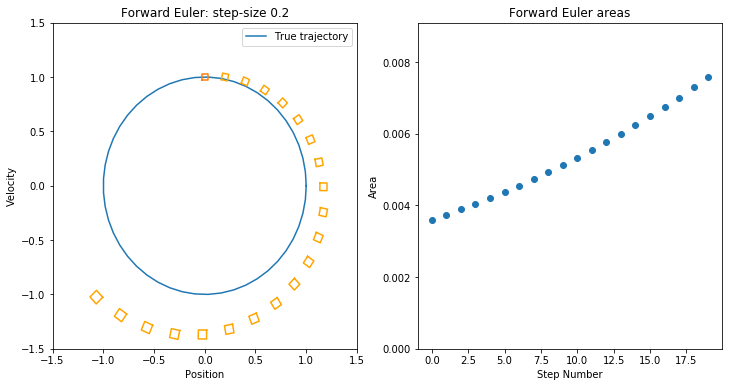

In [63]:
SHO_gradient = lambda x: x
integration_function = forwardEuler_integrate

initial_points = np.array([[-0.03, -0.03, 0.03, 0.03, -0.03], [0.97, 1.03, 1.03, 0.97, 0.97]])

n_steps_total = 20
step_size = 0.2
n_steps_per_leapfrog = 1

fig, ax = plt.subplots(ncols=2, figsize = (12,6))

rad = np.sqrt(init_x*init_x + init_p*init_p)
ax[0].set_xlim(-1.5*rad, 1.5*rad)
ax[0].set_ylim(-1.5*rad, 1.5*rad)

#plot ideal trajectory
theta = np.linspace(0,2*np.pi,50)
ax[0].plot(rad*np.cos(theta), rad*np.sin(theta), label='True trajectory')


ax[0].plot(*initial_points)

new_points = initial_points
areas = np.empty(n_steps_total)
for step_num in range(n_steps_total):
    areas[step_num] = polygon_area(new_points.T)
    
    # compute the updated map
    new_points = np.array([integration_function(point[0], point[1], SHO_gradient, step_size, n_steps_per_leapfrog) for point in new_points.T]).T  
    
    ax[0].plot(*new_points, c='orange')

ax[0].set_title(f'Forward Euler: step-size {step_size}')
ax[0].set_xlabel('Position')
ax[0].set_ylabel('Velocity')
ax[0].legend(loc=1);

ax[1].scatter(range(len(areas)), areas)
ax[1].set_title(f'Forward Euler areas')
ax[1].set_xlabel('Step Number')
ax[1].set_ylabel('Area')
ax[1].set_ylim(0,1.2*np.max(areas))

As the above cell shows, volume is definitely not preserved under the forward Euler integrator.  Worse, we can see that even for moderate step sizes the behavior is unstable.  What should be a circle (the trajectory of the simple harmonic oscillator in phase-space) is actually an exponentially-growing spiral.  Very bad!

Instead, we'll use an integrator known as the **leapfrog integrator**.  This integrator proceeds as follows:
\begin{eqnarray}
p_{\mathrm{int}} &=& p_n -\frac{\Delta t}{2} \nabla_x U(x_n) \\
x_{n+1} &=& x_n + p_{\mathrm{int}} \Delta t  \\
p_{n+1} &=& p_{\mathrm{int}} - \frac{\Delta t}{2} \nabla_x U(x_{n+1})
\end{eqnarray}
This integrator is well-suited for our purposes, as it satisfies both time-reversibility and volume preservation.  You should convince yourself analytically that both of these facts are true.  Below, we demonstrate this numerically for the harmonic oscillator potential.

In [35]:
def leapfrog_integrate(x0, p0, grad_potential, step_size, n_steps):
    
    current_x = x0
    current_p = p0
    for step_num in range(n_steps):
        intermediate_p = current_p - (step_size/2)*grad_potential(current_x)
        next_x = current_x + step_size*intermediate_p
        next_p = intermediate_p - (step_size/2)*grad_potential(next_x)
        
        current_x = next_x
        current_p = next_p
    return current_x,current_p

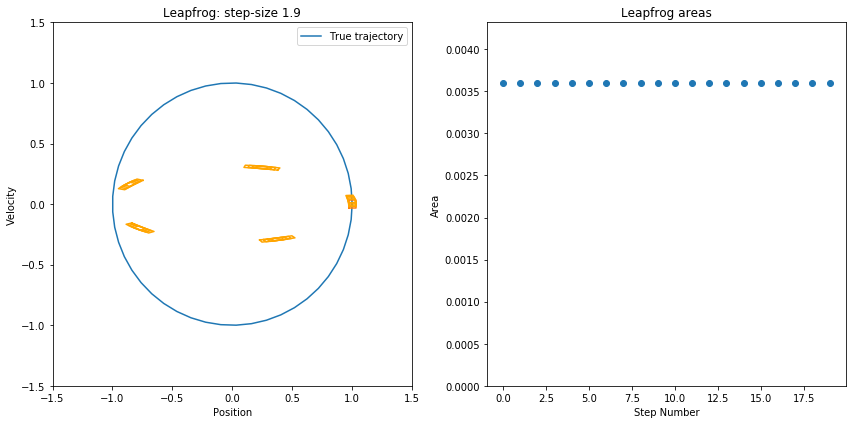

In [65]:
SHO_gradient = lambda x: x
integration_function = leapfrog_integrate

initial_points = np.array([[0.97, 1.03, 1.03, 0.97, 0.97], [-0.03, -0.03, 0.03, 0.03, -0.03]])

n_steps_total = 20
step_size = 1.9
n_steps_per_leapfrog = 1

fig, ax = plt.subplots(ncols=2, figsize = (12,6))

rad = np.sqrt(init_x*init_x + init_p*init_p)
ax[0].set_xlim(-1.5*rad, 1.5*rad)
ax[0].set_ylim(-1.5*rad, 1.5*rad)

#plot ideal trajectory
theta = np.linspace(0,2*np.pi,50)
ax[0].plot(rad*np.cos(theta), rad*np.sin(theta), label='True trajectory')


ax[0].plot(*initial_points)

new_points = initial_points

areas = np.empty(n_steps_total)

for step_num in range(n_steps_total):
    # compute the updated map
    
    areas[step_num] = polygon_area(new_points.T)
    new_points = np.array([integration_function(point[0], point[1], SHO_gradient, step_size, n_steps_per_leapfrog) for point in new_points.T]).T  
    ax[0].plot(*new_points, c='orange')

ax[0].set_title(f'Leapfrog: step-size {step_size}')
ax[0].set_xlabel('Position')
ax[0].set_ylabel('Velocity')
ax[0].legend(loc=1);

ax[1].scatter(range(len(areas)), areas)
ax[1].set_title(f'Leapfrog areas')
ax[1].set_xlabel('Step Number')
ax[1].set_ylabel('Area')
ax[1].set_ylim(0,1.2*np.max(areas))

plt.tight_layout()

Playing with the cell above, you should be able to see that the volume of the occupied region of phase space is constant as the integrator steps forward, even though the leapfrog integration does not match the true trajectory precisely.  

The final property of the leapfrog integrator we need is **reversibility**. Specifically, when we combine the leapfrogging time-step with a flip of the velocity, that combined operation should be an involution.  Above, you were told to check this property analytically.  Below, we test this numerically.  Change the ``arbitrary_gradient`` to whatever function you want, and starting from several different (random) phase-space points, you can see that the leapfrog integrator plus flip, applied twice, returns to the same point.

In [80]:
arbitrary_gradient = lambda x: x + 2*x*x

n_pts = 10
for _ in range(n_pts):
    starting_pt = np.random.randn(2)
    print(f"xi: {starting_pt[0]}, vi: {starting_pt[1]}")
    
    step_size = np.random.randn()
    n_steps = 1
    
    evolved_x, evolved_v = leapfrog_integrate(starting_pt[0], 
                                    starting_pt[1], 
                                    arbitrary_gradient, 
                                    step_size=step_size, 
                                    n_steps=n_steps)
    evolved_v = -1*evolved_v
    end_x, end_v = leapfrog_integrate(evolved_x, 
                                evolved_v, 
                                arbitrary_gradient, 
                                step_size=step_size, 
                                n_steps=n_steps)
    end_v = -1*end_v
    
    print(f"xo: {end_x}, vo: {end_v}")
    print('\n')


xi: -0.3856080909982172, vi: 0.5910448585096124
xo: -0.38560809099821713, vo: 0.5910448585096124


xi: 0.8627729782211496, vi: -1.7428778960394085
xo: 0.8627729782211497, vo: -1.7428778960394087


xi: -0.8457806038187682, vi: -1.4197972653814237
xo: -0.8457806038187682, vo: -1.4197972653814235


xi: -0.6336480501182642, vi: 1.3930082799520485
xo: -0.6336480501182642, vo: 1.3930082799520485


xi: 0.03356877690478871, vi: 0.07448410933677799
xo: 0.03356877690478871, vo: 0.07448410933677799


xi: -0.05668248096385948, vi: -0.14426966503566727
xo: -0.05668248096385947, vo: -0.14426966503566727


xi: -0.3487501124095851, vi: -0.1662810514181741
xo: -0.3487501124095851, vo: -0.16628105141817412


xi: -0.3029284782058789, vi: 0.8586929400108833
xo: -0.30292847820587854, vo: 0.8586929400108836


xi: 0.9726587345749582, vi: 2.0330334638085628
xo: 0.9726587345749582, vo: 2.0330334638085628


xi: -1.0238070444810827, vi: 1.3077672341632105
xo: -1.0238070444810825, vo: 1.3077672341632103




Finally, we are ready to put everything together and explore the behavior of the Hamiltonian Monte Carlo algorithm.

In [212]:
def sample_HMC(potential_energy, potential_gradient, mass=1, dimension=1, num_samples=1000, step_size=0.2):
    """ Samples from a specified probability distribution, using Hamiltonian Monte-Carlo. 
    
    The probability distribution is specified here by giving the potential_energy, such that the 
    pdf is proportional to exp(-1*potential_energy).  The gradient of this potential energy should also be specified."""
    
    samples = np.zeros((num_samples, dimension))

    current_position = np.random.randn(dimension)
    for i in range(num_samples):
        samples[i,:] = current_position
        
        # resample velocity
        current_velocity = np.random.randn(dimension)/np.sqrt(mass)
        current_energy = potential_energy(current_position) + 0.5*np.power(np.linalg.norm(current_velocity),2)*mass

        # Move to new point
        proposed_new_position, proposed_new_velocity = leapfrog_integrate(current_position, current_velocity, potential_gradient, step_size, n_steps=1)

        # Test whether to accept
        new_energy = potential_energy(proposed_new_position) + 0.5*np.power(np.linalg.norm(proposed_new_velocity), 2)*mass
        prob_ratio = np.exp(current_energy - new_energy)   
        accepted = np.random.uniform() < prob_ratio
      
        if accepted:
            current_position = proposed_new_position
            
    return samples

Study the above code to make sure you understand the implementation.  Now let's see the sampler in action, starting with the simple harmonic oscillator (SHO) potential $U(x) = \frac{1}{2}x^2$, which corresponds to the standard Gaussian distribution.  First, we'll just make sure it generates the correct histogram of samples.

In [213]:
SHO_gradient = lambda x: x
SHO_potential = lambda x: 0.5*x*x

n_samples = 20000

SHO_HMC_samples = sample_HMC(SHO_potential, SHO_gradient, dimension=1, mass=1, num_samples=n_samples, step_size=0.3)

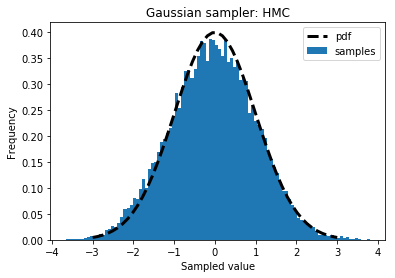

In [214]:
plt.hist(SHO_HMC_samples,bins=100,density=True, label='samples');

#ovelay the pdf
x = np.linspace(-3,3,50)
plt.plot(x, gaussian_pdf(x, 0, 1), linewidth=3, ls='--', color='black', label='pdf')

#add labels, etc.
plt.legend(loc=1)
plt.xlabel('Sampled value')
plt.ylabel('Frequency')
plt.title('Gaussian sampler: HMC');

Now let's look at the autocorrelation and time traces of the samples.  Remember that in the Metropolis algorithm, we could vary the autocorrelation by varying the width of the proposal distribution.  Here, a corresponding parameter is how massive the particle is, i.e. the conversion factor between velocity-squared and kinetic energy.  Drawing on physics intuition, we expect that the more massive the particle is, the slower it will explore the space, and will thus have a larger autocorrelation.  So, if we make the mass smaller, the autocorrelation of the samples should get lower, up to a point.  The cell shows this behavior.

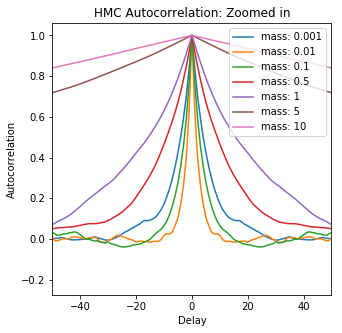

In [221]:
masses = [0.001, 0.01, 0.1, 0.5, 1, 5, 10]
n_samples = 10000
delays = np.arange(-n_samples+1, n_samples)

plt.figure(figsize = (5,5))

autocorrs = {}
samples_HMC = {}

for mass in masses:
    SHO_HMC_samples = sample_HMC(SHO_potential, SHO_gradient, dimension=1, mass=mass, num_samples=n_samples, step_size=0.3)
    samples_HMC[mass] = SHO_HMC_samples[:,0]
    autocorrs[mass] = np.correlate(SHO_HMC_samples[:,0], SHO_HMC_samples[:,0], mode='full')
    autocorrs[mass] /= np.max(autocorrs[mass])
    
    plt.plot(delays, autocorrs[mass], label=f'mass: {mass}')

plt.xlabel('Delay')
plt.ylabel('Autocorrelation')
plt.title('HMC Autocorrelation: Zoomed in')
plt.xlim(-50,+50);
plt.legend(loc=1);

As before, we can look at two extremes of behavior which both give rise to correlated samples.  In the low-mass case, many samples are rejected, so we see long stretches of identical samples, whereas in the high-mass case, the particle makes a very very slow excursion through the phase space. 

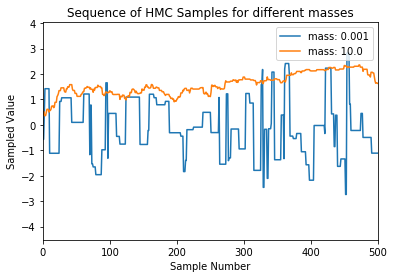

In [223]:
min_mass = np.min(list(samples_HMC.keys()))
max_mass = np.max(list(samples_HMC.keys()))

for mass in [min_mass, max_mass]:
    plt.plot(samples_HMC[mass], label = f'mass: {mass}')
plt.xlim(0,500)
plt.title('Sequence of HMC Samples for different masses')
plt.xlabel('Sample Number')
plt.ylabel('Sampled Value');
plt.legend(loc=1);

We show these plots to reinforce that Hamiltonian Monte-Carlo is similar to the random-walk Metropolis algorithms in many ways, so intuition about the behavior of, say, the Metropolis algorithm can also apply to HMC (at least in low dimensions). 

### Hamiltonian Monte Carlo with isolated modes

As a teaser for the [reading group paper](https://arxiv.org/pdf/1711.09268.pdf), let's look at a distribution which HMC has trouble with: separated 'modes', that is, localized regions with high probability mass.  We will look at separated Gaussians, and show that HMC often gets stuck in one of the Gaussians.  This is analogous to the a particle being trapped in a local minimum because it lacks the energy to escape to the other minimum.  For illustration, we take the pdf to be sum of two unit-variance Gaussians, centered at $x_0$ and $-x_0$.  Here the pdf is 
\begin{equation}
p_{X}^{2G}(x) = \frac{1}{2\sqrt{2\pi}}\left( e^{-(x-x_0)^2/2} + e^{-(x+x_0)^2/2} \right),
\end{equation}
with corresponding energy
\begin{equation}
U_{2G}(x) = -\log{ \left( e^{-(x-x_0)^2/2} + e^{-(x+x_0)^2/2} \right) }
\end{equation}
and energy gradient
\begin{equation}
\frac{d}{dx}U_{2G}(x) = \frac{(x-x_0)e^{-(x-x_0)^2/2} + (x+x_0)e^{-(x+x_0)^2/2}}{ e^{-(x-x_0)^2/2} + e^{-(x+x_0)^2/2}}
\end{equation}

In [294]:
def two_gauss_pdf(x0):
    return lambda x: 1/(2*np.sqrt(2*np.pi))*(np.exp(-(x-x0)*(x-x0)/2) + np.exp(-(x+x0)*(x+x0)/2))

def two_gauss_energy_fun(x0):
    return lambda x: -np.log(np.exp(-(x-x0)*(x-x0)/2) + np.exp(-(x+x0)*(x+x0)/2))

def two_gauss_grad_fun(x0):
    return lambda x: ((x-x0)*np.exp(-(x-x0)*(x-x0)/2) + (x+x0)*np.exp(-(x+x0)*(x+x0)/2))/(np.exp(-(x-x0)*(x-x0)/2) + np.exp(-(x+x0)*(x+x0)/2))

Let's start with $x_0$ just slightly higher than the variance, so the pdf has a small dip in the middle.

In [295]:
x0 = 1.5

TwoGauss_potential = two_gauss_energy_fun(x0)
TwoGauss_gradient = two_gauss_grad_fun(x0)
TwoGauss_pdf = two_gauss_pdf(x0)

n_samples = 5000

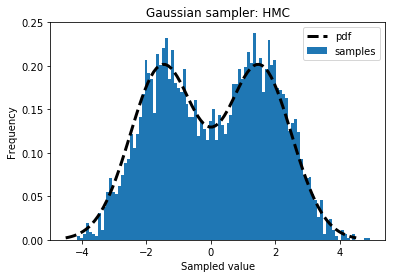

In [292]:
TwoGauss_HMC_samples = sample_HMC(TwoGauss_potential, TwoGauss_gradient, dimension=1, mass=.1, num_samples=n_samples, step_size=0.3)

plt.hist(TwoGauss_HMC_samples,bins=100,density=True, label='samples');

#ovelay the pdf
x = np.linspace(-x0-3,x0+3,100)
plt.plot(x, TwoGauss_pdf(x), linewidth=3, ls='--', color='black', label='pdf')

#add labels, etc.
plt.legend(loc=1)
plt.xlabel('Sampled value')
plt.ylabel('Frequency')
plt.title('Gaussian sampler: HMC');

Already in this case, we can see an interesting feature of the behavior of this sampler: the heights of the two peaks in the histogram are not usually equal.  Why could this be?  Looking at the record of the samples gives the answer:

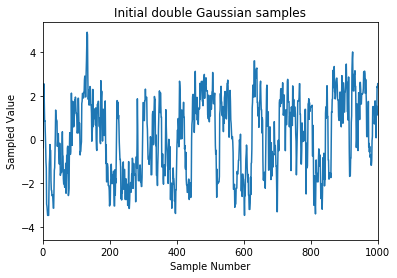

In [293]:
plt.plot(TwoGauss_HMC_samples)
plt.xlim(0,1000)
plt.title('Initial double Gaussian samples')
plt.xlabel('Sample Number')
plt.ylabel('Sampled Value');

It seems that the sampler is getting slightly stuck in one of the potential wells for a while, as we expected.  We can make this behavior more evident by increasing the separation of the wells.  Go back and run the same code for x0 = 3, 5, and 10.  You should see vast stretches of getting stuck in each potential well as the separation increases.  So here we have found one problem of Hamiltonian Monte Carlo: it doesn't handle isolated modes very well. This is one problem which the paper we will discuss hopes to address. 

## Further reading

There are many great references on Hamiltonian Monte Carlo which I used when preparing this.
* [A video](https://www.youtube.com/watch?v=a-wydhEuAm0) by Ben Lambert which explains the connection betwen energy and probability in more detail than I have done here
* [A shorter blog post](http://arogozhnikov.github.io/2016/12/19/markov_chain_monte_carlo.html) by Alex Rogozhnikov with *amazing* visualizations
* [A paper](https://arxiv.org/pdf/1701.02434.pdf) with an emphasis on *why* HMC works so well in high dimensions, including the connection to differential geometry, which I did not discuss at all here (because I don't know it)
* [A book chapter](https://arxiv.org/pdf/1206.1901.pdf) by [Radford Neal](https://www.cs.toronto.edu/~radford/), very detailed and pedagogical.